In [1]:
using BenchmarkTools
using Plots

include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

In [6]:
cj.planck18_bkg.Ω_m0
cj.growth_factor(0)

0.7871200975145634

In [ ]:
using Plots

z = 10 .^(range(-2,stop=4,length=100))


Ω_r = MyCosmology.Ω_r.(z)
Ω_m = MyCosmology.Ω_m.(z)
Ω_Λ = MyCosmology.Ω_Λ.(z)

ρ_r = MyCosmology.ρ_r_Msun_Mpc3.(z)
ρ_m = MyCosmology.ρ_m_Msun_Mpc3.(z)
ρ_Λ = MyCosmology.ρ_Λ_Msun_Mpc3.(z)
ρ_c = MyCosmology.ρ_c_Msun_Mpc3.(z)

plot(z, MyCosmology.growth_factor.(z).*(1 .+z), xscale=:log10, color=:blue)
plot!(z, MyCosmology.growth_factor_Carroll.(z).*(1 .+z), xscale=:log10, yscale=:log10, color=:red)

In [105]:
using OrdinaryDiffEq

function numerical_growth_a(ddy, dy, y, p, a)
    Ωm = cj.Ω_vs_a(cj.Matter, a, cj.edsPlanck18_bkg)
    Ωm_0 = cj.Ω_vs_a(cj.Matter, 1.0, cj.edsPlanck18_bkg)
    Ωr = cj.Ω_vs_a(cj.Radiation, a,cj.edsPlanck18_bkg)
    
    ddy .= - (5 - 3/2 * Ωm - 2*Ωr) * dy / a  - (3*(1-Ωm) - 2*Ωr)*y/ a^2 .+ p .* Ωm./Ωm_0 ./ a^3
end

function numerical_growth_lna(ddy, dy, y, p, x)
    Ωm = cj.Ω_vs_a(cj.Matter, exp(x), cj.planck18_bkg)
    Ωm_0 = cj.Ω_vs_a(cj.Matter, 1.0, cj.planck18_bkg)
    Ωr = cj.Ω_vs_a(cj.Radiation, exp(x), cj.planck18_bkg)

    ddy .= - (4.0- 3.0/2.0 * Ωm - 2.0*Ωr) * dy  - (3.0*(1.0-Ωm) - 2.0*Ωr)*y .+ p .* Ωm./Ωm_0 .* exp.(.-x)
end

a_init_pmf = cj.z_to_a(1100)
a_init_dens = cj.z_to_a(1100)

x_init_pmf = log(a_init_pmf)
x_init_dens = log(a_init_dens)

prob_pmf = SecondOrderODEProblem(numerical_growth_lna, [0.0], [0.0], (x_init_pmf, -0.01), 1.0)
sol_pmf = solve(prob_pmf, Euler(), dt=0.001);

prob_dens = SecondOrderODEProblem(numerical_growth_lna, [0.0], [1.0], (x_init_dens, -0.01), 0.0)
sol_dens = solve(prob_dens, Euler(), dt=0.001);

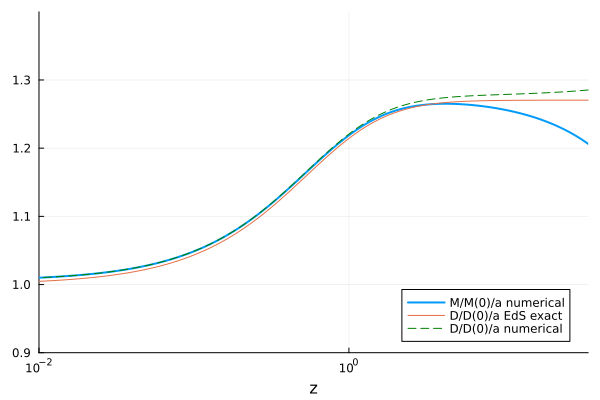

In [106]:
#Plot
y_pmf = [sol_pmf.u[i][2] for i in 1:length(sol_pmf.u)]
y_dens = [sol_dens.u[i][2] for i in 1:length(sol_dens.u)]

z_pmf = cj.a_to_z.(exp.(sol_pmf.t))
z_dens = cj.a_to_z.(exp.(sol_dens.t))

#z_pmf = cj.a_to_z.(sol_pmf.t)
#z_dens = cj.a_to_z.(sol_dens.t)

M = y_pmf ./ (1 .+ z_pmf ) / (cj.hubble_constant()^2)
D = y_dens ./ (1 .+ z_dens )

plot(z_pmf, M ./ M[end] .* (1.0 .+ z_pmf) , linewidth=2, xaxis = "z", xscale=:log10, label="M/M(0)/a numerical")
plot!(z_dens, cj.growth_factor.(z_dens) / cj.growth_factor.(0)  .* (1.0 .+ z_dens), label="D/D(0)/a EdS exact", xlim=[1e-2, 35], ylim=[0.9, 1.4])
plot!(z_dens, D ./ D[end] .* (1.0 .+ z_dens), linestyle=:dash, color="green", label="D/D(0)/a numerical", xscale=:log10)


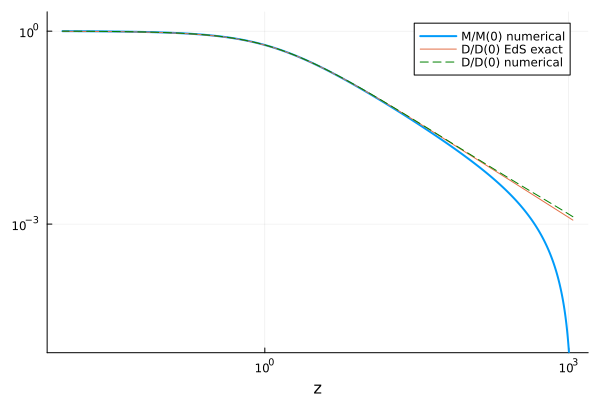

In [308]:
#Plot
y_pmf = [sol_pmf.u[i][2] for i in 1:length(sol_pmf.u)]
y_dens = [sol_dens.u[i][2] for i in 1:length(sol_dens.u)]

z_pmf = cj.a_to_z.(exp.(sol_pmf.t))
z_dens = cj.a_to_z.(exp.(sol_dens.t))

#z_pmf = cj.a_to_z.(sol_pmf.t)
#z_dens = cj.a_to_z.(sol_dens.t)

M = y_pmf ./ (1 .+ z_pmf ) / (cj.hubble_constant()^2)
D = y_dens ./ (1 .+ z_dens )

plot(z_pmf[M .> 0], M[M .> 0] ./ M[end] , linewidth=2, xaxis = "z", xscale=:log10, label="M/M(0) numerical")
plot!(z_dens, cj.growth_factor.(z_dens) / cj.growth_factor.(0), label="D/D(0) EdS exact")
plot!(z_dens[D .> 0], D[D .> 0] ./ D[end], linestyle=:dash, color="green", label="D/D(0) numerical", xscale=:log10, yscale=:log10, ylim=[1e-5, 2])

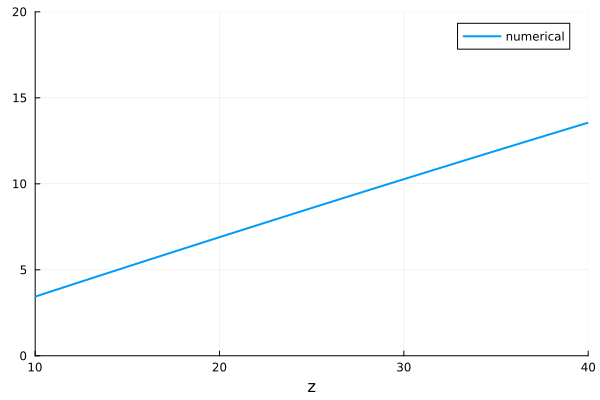

In [296]:
error = 100 .*(1 .- M.^2 ./ M[end]^2 ./ (D.^2 ./ D[end]^2 ))
plot(z,  error, linewidth=2, xaxis = "z", label="numerical", xlim=[10, 40], ylim=[0, 20])

In [95]:
using SpecialFunctions
using QuadGK
import Unitful: km, s, Gyr, K, Myr, NoUnits, Gauss, A, kg
import UnitfulAstro: Mpc, Gpc, Msun
import PhysicalConstants.CODATA2018: μ_0, c_0, G as G_NEWTON

""" σB0 in nG result in Mpc^{-1}"""
function kA_approx(σB0::Real, nB::Real)
    return (σB0^2 / (2*π)^(3.0+nB) / 4.2e+5  )^(-1.0/(5.0+nB))
end

function λB(λ::Real, σB0::Real, nB::Real)
    res = 16.0 * π / 25.0 * (σB0 * 1e-9 * 1e-4 * kg / A / s^2)^2/(μ_0 * G_NEWTON * cj.ρ_Msun_Mpc3(cj.Matter) * cj.ρ_Msun_Mpc3(cj.Baryons) * Msun^2 / Mpc^6) * λ^(3+nB) / Mpc^2 |> NoUnits
    return res^(1.0/(5+nB))
end

""" σB0 in nG, result in Mpc^{-1} """
function kB(σB0::Real, nB::Real)
    return 2*π/λB(1, σB0, nB)
end

""" result in units of σB0^2 * Mpc^(3 + nB)"""
function amplitude_B0(σB0::Real, nB::Real)
    return σB0^2 * (2*π)^2 / gamma((nB+3.0)/2.0)
end

""" σB0 in nG result in nG^2 * Mpc^3 """
function pmf_power_spectrum(k::Real, σB0::Real, nB::Real)
    kA = kA_approx(σB0, nB)
    return amplitude_B0(σB0, nB) * k^nB * exp(-2*k^2/kA^2)
end

function _to_integrate_2(k1::Real, μ::Real, k::Real, σB0::Real, nB::Real)
    return pmf_power_spectrum(sqrt(k^2 + k1^2 - 2*k*k1*μ), σB0, nB) * (k^2 + (k^2-2*k*k1*μ)*μ^2)
end

function _to_integrate_1(k1::Real, k::Real, σB0::Real, nB::Real)
    return  k1^2 * pmf_power_spectrum(k1, σB0, nB) * quadgk(μ -> _to_integrate_2(k1, μ, k, σB0, nB), -1.0, 1.0, rtol=1e-12)[1]
end

""" σB0 in nG, result in s^(-4) Mpc^3 """
function matter_pmf_spectrum(k::Real, σB0::Real, nB::Real)
    
    res = quadgk(lnk1 -> _to_integrate_1(exp(lnk1), k, σB0, nB)*exp(lnk1), -5, +15, rtol=1e-3)[1]
    
    fb = cj.Ω(cj.Baryons, 0.0) / cj.Ω(cj.Matter, 0.0)
    ρb_0 = cj.ρ_Msun_Mpc3(cj.Baryons, 0.0) * Msun / Mpc^3

    Π = ( (fb * (k / Mpc ))^2 / ( 4*π * μ_0 * ρb_0)^2 * res * (1e-9 * 1e-4 * kg / A / s^2)^4 * Mpc )/ (s^(-4) * Mpc^3) |> NoUnits

    return 2.80e+76 * Π / (1.0  + k^2 / kB(σB0, nB)^2)^2

end



matter_pmf_spectrum

In [96]:
λB(1, 0.2, -2.5) 
matter_pmf_spectrum(10, 0.02, -2.5)


1.876710715295414e-5

In [97]:
kh_array = 10.0.^range(-4, 5, 50)
res = matter_pmf_spectrum.(kh_array * cj.planck18_bkg.h, 0.02, -2.5) * (cj.planck18_bkg.h)^3 ;

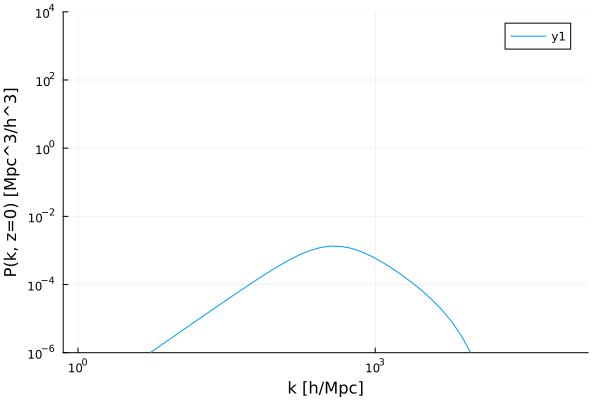

In [120]:
plot(kh_array, res, xscale=:log10, yscale=:log10, ylim=[1e-6, 1e+4], xlabel="k [h/Mpc]", ylabel="P(k, z=0) [Mpc^3/h^3]")

In [109]:
(M[end] / (km / Mpc)^2 |> NoUnits)^2

3.811318970423844e76

In [59]:
using QuadGK

""" Give the exact solution of the ODE y'' = py' + qy + r  """
function exact_ode_solver(p::Function, q::Function, r::Function;
                    x0::Real = 0, y0::Real = 0, dy0::Real = 0, rtol::Float64 = 1e-6)

    """ 
    the method is based on writting y' = u and diagonalising 
    the system of equation satisfied by the vector (u, y)
    -----
    if we denote P = [-1 λ2 ; 1 λ1]/Δ the matrix of the change of base
    and M = [a b; 1 0] then PMP^{-1} = D = diag(λ1, λ2)
    ----
    we write w = P * (u v) and k = P * (r 0)
    therefore w' = Dw + k
    """
    
    Δ(x::Real) = sqrt(p(x)^2 + 4.0 * q(x))
    λ(x::Real) = [1/2.0 *(p(x)-Δ(x)), 1/2.0 *(p(x)+Δ(x))]
    k(x::Real) = r(x) / Δ(x) * [-1, 1]

    """ 
    wh(x) = exp(+int(λ, x0, x)) solution of the homogeneous part
    wp(x) = wh(x) * int(k/wh, x0, x) bit of the particular solution from the constant variation
    the total solution is c * wh + wp
    """
    wh(x::Real) = exp.(quadgk(t -> λ(t), x0, x, rtol=rtol)[1])
    wp(x::Real) = wh(x) .* quadgk(t -> (k(t) ./ wh(t)), x0, x, rtol=rtol)[1]

    """ the constants for the solutions are """
    c = [(-dy0 + λ(x0)[2]*y0) / Δ(x0),  (dy0 - λ(x0)[1]*y0) /Δ(x0)]

    """ going back to the (u, y) space """
    y(x::Real) = sum( c .* wh(x) + wp(x) )
    u(x::Real) = sum( c .* λ(x) .* wh(x) + wp(x) )

    return y, u

end


exact_ode_solver

In [167]:
function solve_growth_factor(pmf::Bool=true, cosmo::cj.BkgCosmology = cj.planck18_bkg; rtol::Real =1e-6)
    
    p(x::Real) = -(4.0 - 3.0/2.0*cj.Ω_vs_a(cj.Matter, exp(x), cosmo) - 2.0*cj.Ω_vs_a(cj.Radiation, exp(x), cosmo)) 
    q(x::Real) = -(3.0*(1- cj.Ω_vs_a(cj.Matter, exp(x), cosmo) ) - 2.0* cj.Ω_vs_a(cj.Radiation, exp(x), cosmo) )
    r(x::Real) = pmf ? exp(-x) * cj.Ω_vs_a(cj.Matter, exp(x), cosmo) / cj.Ω_vs_a(cj.Matter, 1.0, cosmo) : 0.0

    x0  = pmf ? log(cj.z_to_a(1100.0)) : log(cj.z_to_a(200.0))
    y0  = pmf ? 0.0 : 1.0
    dy0 = 0.0

    y, _ = exact_ode_solver(p, q, r, x0=x0, y0=y0, dy0=dy0, rtol = rtol)

    
    function growth(z::Real) 
        res = y(log(cj.z_to_a(z))) / (1 + z)
        pmf && (res /= (3.240779289444365e-20 * cj.hubble_constant(cosmo))^2 )
        return res
    end

    return growth
end

function solve_growth_factor_a(pmf::Bool=true, cosmo::cj.BkgCosmology = cj.planck18_bkg; rtol::Real=1e-6)
    
    p(x::Real) = -(5.0 - 3.0/2.0*cj.Ω_vs_a(cj.Matter, x, cosmo) - 2.0*cj.Ω_vs_a(cj.Radiation, x, cosmo)) / x
    q(x::Real) = -(3.0*(1- cj.Ω_vs_a(cj.Matter, x, cosmo) ) - 2.0* cj.Ω_vs_a(cj.Radiation, x, cosmo) ) / x^2
    r(x::Real) = pmf ? 1.0/x^3 * cj.Ω_vs_a(cj.Matter, x, cosmo) / cj.Ω_vs_a(cj.Matter, 1.0, cosmo) : 0.0

    x0  = pmf ? cj.z_to_a(1100.0) : cj.z_to_a(200.0)
    y0  = pmf ? 0.0 : 1.0
    dy0 = 0.0

    y, _ = exact_ode_solver(p, q, r, x0=x0, y0=y0, dy0=dy0, rtol = rtol)

    
    function growth(z::Real) 
        res = y(cj.z_to_a(z)) / (1 + z)
        pmf && (res /= (3.240779289444365e-20 * cj.hubble_constant(cosmo))^2 )
        return res
    end

    return growth
end

solve_growth_factor_a (generic function with 5 methods)

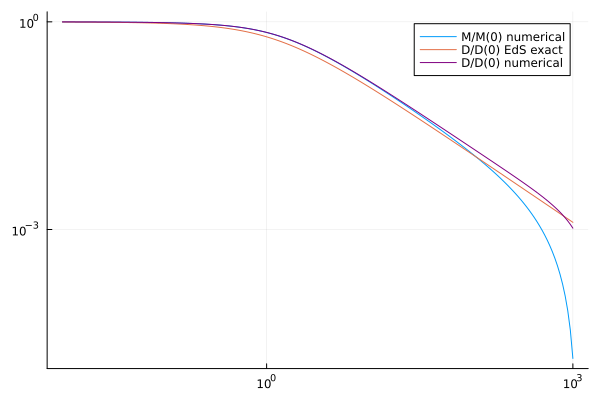

In [119]:
z_arr = 10.0.^range(-2, 3, 200)
x_arr = log.(cj.z_to_a.(z_arr))

M = solve_growth_factor()
D = solve_growth_factor(false)

plot(z_arr,  M.(z_arr) / M(0), label="M/M(0) numerical", xscale=:log10, yscale=:log10)
plot!(z_arr, cj.growth_factor.(z_arr) / cj.growth_factor.(0), label="D/D(0) EdS exact")
plot!(z_arr, D.(z_arr) / D(0), label="D/D(0) numerical", color="purple")

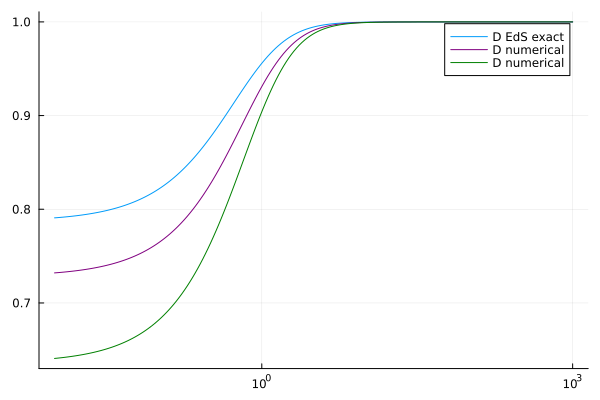

In [169]:
z_arr = 10.0.^range(-2, 3, 200)

D = solve_growth_factor_a(false, cj.edsPlanck18_bkg, rtol=1e-12)
D_2 = solve_growth_factor(false, cj.edsPlanck18_bkg, rtol=1e-12)

plot(z_arr, cj.growth_factor.(z_arr) .* (1 .+ z_arr), label="D EdS exact", xscale=:log10)
plot!(z_arr, D.(z_arr) .* (1 .+ z_arr), label="D numerical", color="purple")
plot!(z_arr, D_2.(z_arr) .* (1 .+ z_arr), label="D numerical", color="green")

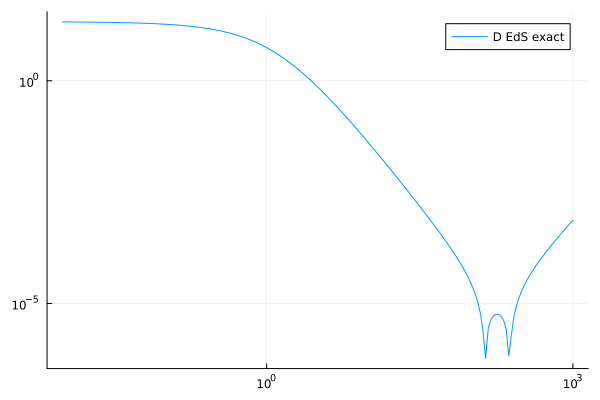

In [124]:
z_arr = 10.0.^range(-2, 3, 200)
x_arr = log.(cj.z_to_a.(z_arr))

D = solve_growth_factor(false, cj.edsPlanck18_bkg)

plot(z_arr, 200.0*abs.(cj.growth_factor.(z_arr) - D.(z_arr))./(cj.growth_factor.(z_arr) + D.(z_arr)), label="D EdS exact", xscale=:log10, yscale=:log10)

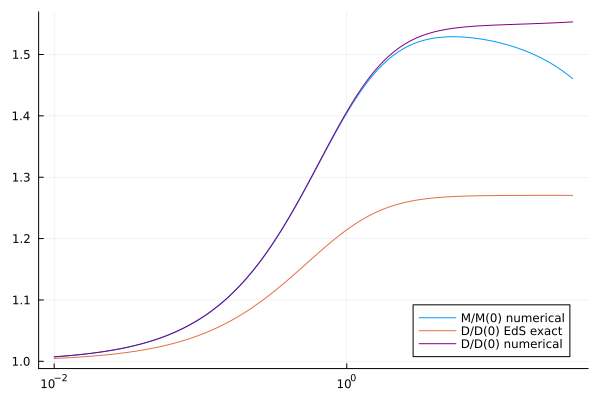

In [128]:
z_arr = 10.0.^range(-2, log10(35.0), 200)
x_arr = log.(cj.z_to_a.(z_arr))

M = solve_growth_factor(true)
D = solve_growth_factor(false)

plot(z_arr,  M.(z_arr) / M(0) .* (1.0 .+ z_arr), label="M/M(0) numerical", xscale=:log10)
plot!(z_arr, cj.growth_factor.(z_arr) / cj.growth_factor.(0) .* (1.0 .+ z_arr), label="D/D(0) EdS exact")
plot!(z_arr, D.(z_arr) / D(0) .* (1.0 .+ z_arr), label="D/D(0) numerical", color="purple")